# 2D EKF

In this exercise, we will show that you only need to replace the matrixes to accommodate the two-dimensional nature of the flight and rest of the estimation code stays the same. 
As an example let us consider a drone which is constrained in the vertical direction thus $z=const$ and it can only move in the horizontal direction by changing the roll angle. 
<img src="EKF2D.png" width="500" height="500">
Contrary to the one-dimensional case the flight in two dimensions require more involved mathematics.
The state vector has the next form $X=[\phi,\dot{y},y]^T$ The control input for the drone is the roll angle $\phi$. **Note:** that in past we has the control input which characterized the thrust - $\bar{u}_1$ and torque $\bar{u}_2 \sim \ddot{\phi}$. But we will use the simplified controls as the goal is to show the estimation procedure and not to get lost in the complexity of the controller mathematics. 


In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
from math import sin, cos
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import jdc
from ipywidgets import interactive
from scipy.stats import multivariate_normal

import time 

pylab.rcParams['figure.figsize'] = 10, 10

In [2]:
pylab.rcParams['figure.figsize'] = 10, 10

# EKF 
To perform the predict and update steps for the 2D EKF we need to know the mean and the standard deviation for measurement and motion. The measurement error is related to the fact of how good is our measuring tool, and the motion error is associated with the drone of how well does it execute the given command.

### Transition model and predict step
During the flight, we directly set the roll angle  $u_t=[\phi]$.
Thus the value of $g(x_t,u_t,\Delta t)$, which represents transition function will have the next form for the given state $x_t$, control input of $u_t$ and time step $\Delta t$.
$$
g(x_t,u_t,\Delta t)=\begin{bmatrix} u_{t,\phi} \\ \dot{y} - \sin{(\phi)}dt \\ y+\dot{y} dt   \end{bmatrix}
$$

Thus the derivative will be represented by the given equation:
$$
g'(x_t,u_t,\Delta t)=\begin{bmatrix} 0 & 0 & 0 \\ -\cos{(\phi)} dt & 1 & 0 \\ 0 & dt & 1   \end{bmatrix}
$$
Please note that we are assuming for simplicity that we are having the thrust value of 1. 
Also, the drone is confined in the vertical direction and only can move along the horizontal $y$ axis. 
This will result that acceleration in the horizontal direction has the next form $\ddot{y}=\sin{(\phi)}$.

### Predict 
Now that we have implemented the proper expressions for $g$ and $g'$ we can perform the predicting step. Please note that the given step is exactly like the one that you already implemented for one-dimensional case.

In [3]:
class EKF:
    def __init__(self,
                 motion_error,             # Motion noise
                 angle_sigma,              # Angle sigma
                 velocity_sigma,           # Velocity uncertainty
                 position_sigma,           # Position unsertanty
                 dt                        # dt time between samples 
                ):
        
        # Sensor measurement covariance
        self.r_t = np.array([[motion_error**2]])
        
        # Motion model noise for angle, velocity and position
        self.q_t = np.array([[angle_sigma**2,0.0,0.0],
                             [0.0,velocity_sigma**2,0.0],
                             [0.0,0.0,position_sigma**2]]) 
        
        self.dt = dt
        
        self.mu = np.array([0])
        self.sigma = np.array([0])
        
        self.mu_bar = self.mu
        self.sigma_bar = self.sigma
        
    def initial_values(self,mu_0, sigma_0):
        self.mu= mu_0
        self.sigma = sigma_0
        

    def g(self, 
          u       # The new input
         ):
        '''
        Calculates g matrix for transition model 
        '''

        current_phi, current_y_dot, current_y = self.mu

        # TODO: return the g matrix 
        new_phi = u
        new_y_dot = current_y_dot - sin(current_phi) * self.dt
        new_y = current_y + current_y_dot * self.dt

        g = np.array([new_phi, new_y_dot, new_y])

        return g

    def g_prime(self):
        '''
        Calculates the g prime matrix
        '''
        current_phi = self.mu[0]

        # TODO: return the derivative of the g matrix 
        g_prime = np.array([[0.0, 0.0, 0.0],
                            [-cos(current_phi) * self.dt, 1.0, 0.0],
                            [0.0, self.dt, 1.0]])

        return g_prime


    def predict(self, u):

        previous_covariance = self.sigma
        mu_bar = self.g(u)
        G_now  = self.g_prime()
        sigma_bar = np.matmul(G_now,np.matmul(previous_covariance,np.transpose(G_now))) + self.q_t

        self.mu_bar  = mu_bar 
        self.sigma_bar = sigma_bar

        return mu_bar, sigma_bar


# Testing the Predict function
The state vector has the next form 
$$
X = \begin{bmatrix} \phi\\ \dot{y} \\ y \end{bmatrix}
$$

First, we will declare the initial condition and then execute the prediction and you will be able to see that the prediction for 2D is no different from the 1D that you already have seen. 

In [4]:
y = 1.0                         # Initial position
y_dot = 1.0                     # initial velocity
phi = 0.1                       # Initial roll angle

dt = 1.0                        # The time difference between measures
motion_error = 0.1              # Motion error 
angle_error = 0.1               # Angle uncertainty 
velocity_sigma = 0.1            # Velocity uncertainty
position_sigma = 0.1            # Position uncertainty

mu_0 = np.array([[phi],[y_dot],[y]]) 
sigma_0 = np.matmul(np.identity(3), np.array([angle_error,velocity_sigma,position_sigma]))

u = np.array([phi]) 


Initializing the object and predicting the next state. 

In [5]:
# Initialize the object
MYEKF=EKF(motion_error,angle_error,velocity_sigma,position_sigma,dt)

# Input the initial values 
MYEKF.initial_values(mu_0, sigma_0)

# Call the predict function
mu_bar, sigma_bar = MYEKF.predict(u)

print('mu_bar = \n',mu_bar)
print('sigma_bar = \n', sigma_bar)

mu_bar = 
 [[ 0.1       ]
 [ 0.90016658]
 [ 2.        ]]
sigma_bar = 
 [[ 0.01        0.00049958  0.20049958]
 [ 0.          0.01049958  0.20049958]
 [ 0.          0.00049958  0.21049958]]


Plotting the initial and predicted configuration spaces. 

In [6]:
from StateSpaceDisplayFor2D import state_space_display_predict

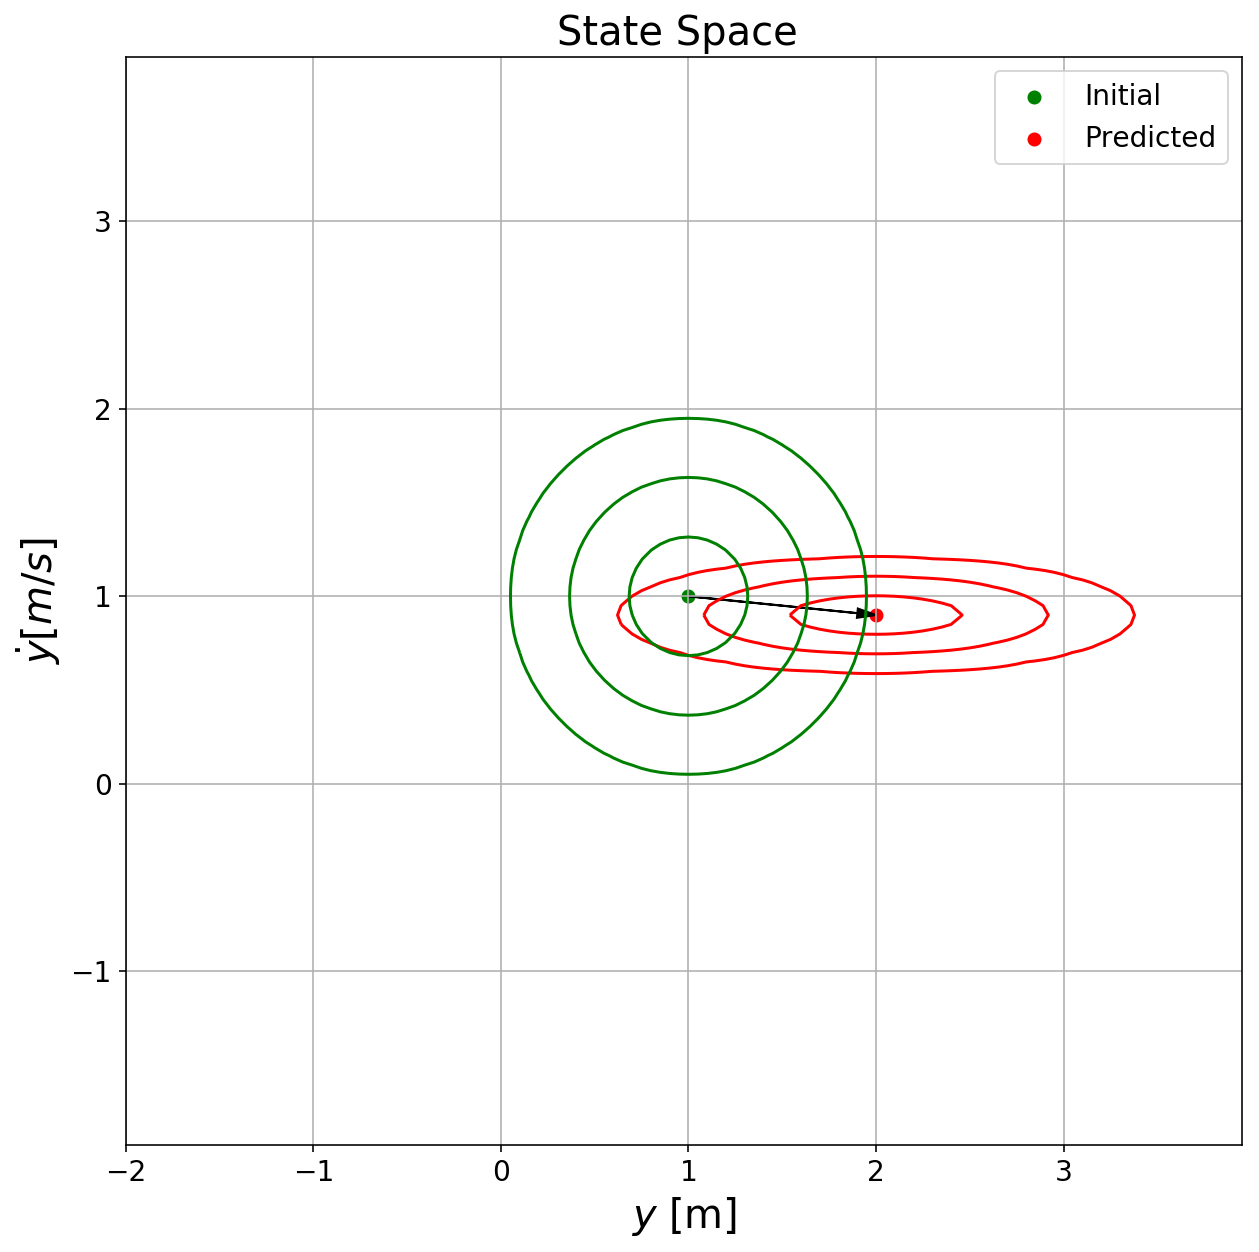

In [7]:
state_space_display_predict(y,y_dot,mu_0,sigma_0,mu_bar,sigma_bar)

# Update step

The given step is similar to the one that you already implemented in the one-dimensional case the only difference is that in two dimensions you have different $h$ and $h'$ matrixes. 

$$
h= \frac{y_{wall}-y}{\cos{(\phi)}}
$$

$$
h'= \begin{bmatrix} \frac{(y_{wall}-y)\sin{(\phi)}}{\cos^2{(\phi)}} & 0 & \frac{-1}{\cos{(\phi)}} \end{bmatrix}
$$

we assume that $y_{wall} =0$.

In [8]:
%%add_to EKF

def h_prime(self,mu_bar):
    
    predicted_phi, predicted_y_dot, predicted_y = mu_bar
    # TODO: Calculate the derivative of the h matrix
    return np.array([[float(-predicted_y*sin(predicted_phi)/cos(predicted_phi)**2), 0.0, -1/cos(predicted_phi)]]) 

def h(self,mu_bar):
    
    predicted_phi, predicted_y_dot, predicted_y = mu_bar
    # TODO: Calculate the h matrix 
    return np.array([-predicted_y / cos(predicted_phi)]) 

def update(self, z):
    
    H = self.h_prime(self.mu_bar)
    S = np.matmul(np.matmul(H,self.sigma_bar),np.transpose(H)) + self.r_t     
    K = np.matmul(np.matmul(self.sigma_bar,np.transpose(H)),np.linalg.inv(S))

    mu = self.mu_bar + np.matmul(K,(-z-self.h(self.mu_bar)))
    sigma = np.matmul((np.identity(3) - np.matmul(K,H)),self.sigma_bar)
    
    self.mu=mu
    self.sigma=sigma
    
    return mu, sigma
    

# The measuring results 

We will update the estimated position based on the measured value. 

In [9]:
measure = 2.05 
mu_updated, sigma_updated = MYEKF.update(measure)
print('updated mean = \n', mu_updated)
print('updated sigma = \n', sigma_updated)

updated mean = 
 [[ 0.13084376]
 [ 0.9307047 ]
 [ 2.03206122]]
updated sigma = 
 [[  8.44325342e-03   3.42456287e-05   5.98614822e-03]
 [ -1.54132032e-03   1.00388568e-02   7.91363828e-03]
 [ -1.61819432e-03   1.58778621e-05   8.30833428e-03]]


### Plotting the update 


In [10]:
from StateSpaceDisplayFor2D import state_space_display_updated

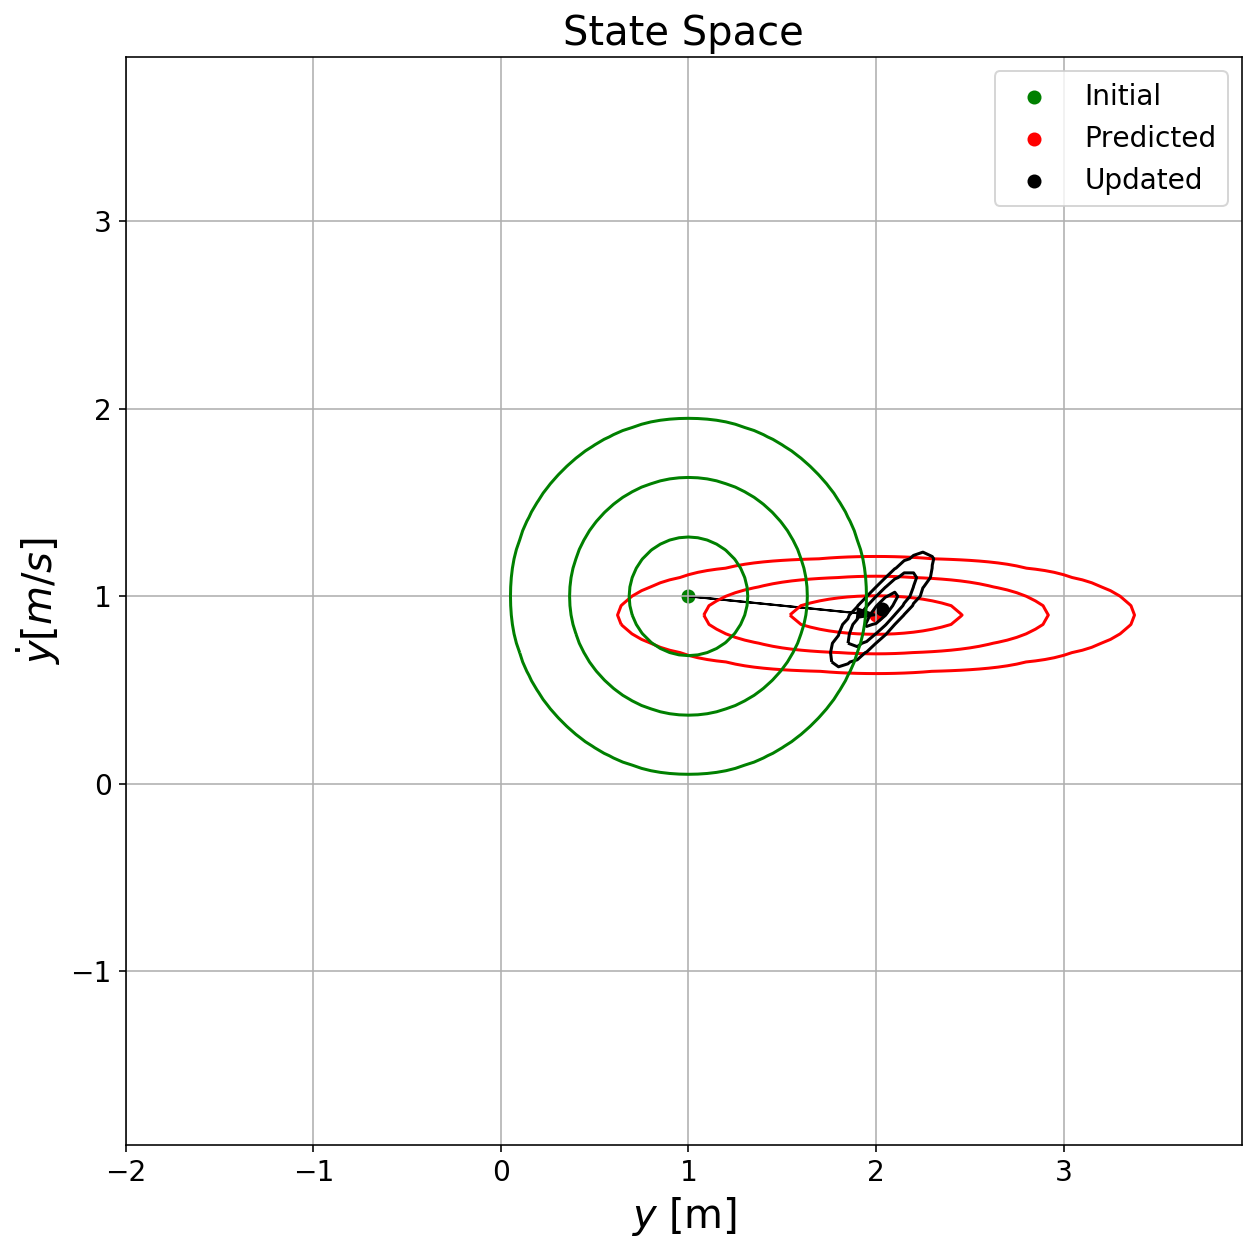

In [11]:
state_space_display_updated(y,y_dot,mu_0,sigma_0,mu_bar,sigma_bar,mu_updated,sigma_updated)

# EKF with PID 

In [12]:
from PIDcontroller import PIDController_with_ff
from PathGeneration import flight_path
total_time = 10.0
dt = 0.01

t, z_path, z_dot_path, z_dot_dot_path =  flight_path(total_time, dt,'constant' )

Introducing the simple IMU unit which simulates the measurement noise.

In [13]:
class IMU:
    def __init__(self):
        pass
        
    def measure(self,z,sigma=0.001):
        return z + np.random.normal(0.0, sigma)

Creating a simple drone object which captures the dynamics of the 2D drone. 

In [14]:
class Drone:
    def __init__(self,
                phi,
                y_dot,
                y):
        
        self.X = np.array([phi,y_dot,y])
        
        
    def advance_state(self, phi_new, dt): 
        self.X = np.array([phi_new, self.X[1]-np.sin(phi_new)*dt, self.X[2]+self.X[1]*dt])
        
        return self.X 

### Comparing the executed paths based on different control inputs 
We will compare the position of the drone when controller only relied on the direct measurements of the distance to the case when controller received the estimated position from the EKF filter. 

In [15]:
from DronewithPIDControllerEKF2D import DronewithPIDEKF

In [16]:
FlyingDrone = DronewithPIDEKF(z_path, z_dot_path, z_dot_dot_path, t, dt,IMU,Drone,EKF)

In [17]:
interactive_plot = interactive(FlyingDrone.PID_controler_with_EKF, 
                               angle_error = (0.0, 0.01, 0.001),
                               position_sigma = (0.0, 0.05, 0.001),
                               motion_sigma = (0.0, 0.05, 0.001))
output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot

A Jupyter Widget

This section will allow you to test the different PID controller parameters and compare flight path when using the direct measurement and the EKF estimated value to control the drone. 

In [18]:
from DronewithPIDControllerEKF2D import DronewithPIDKFKnobs

In [19]:
FlyingDroneKnobs = DronewithPIDKFKnobs(z_path, z_dot_path, z_dot_dot_path, t, dt,IMU,Drone,EKF)

In [20]:
interactive_plot = interactive(FlyingDroneKnobs.PID_controler_with_KF_knobs,
                               k_p=(5.0, 35.0, 1),
                               k_d=(0.0,10,0.5), 
                               k_i=(0.0,10,0.5), 
                               angle_error = (0.0, 0.1, 0.001),
                               position_sigma = (0.0, 0.1, 0.001),
                               motion_sigma = (0.0, 0.1, 0.001))

output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot

A Jupyter Widget